In [13]:
import os
import sys
import re
import shutil
import time
import pickle
import joblib
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

COLORS = ["darkorange","royalblue","slategrey"]

In [14]:
# import common functions and variables
from CapstoneCommon import engineer_features, fetch_ts, convert_to_ts, fetch_data

In [15]:
# load data 
# myts = pd.read_csv("data/cs-train/ts-data/ts-all.csv")
# read all the training data
data_dir = os.path.join("data","cs-train")
print(data_dir)
print("...fetching data")

# load all json formatted invoice files into a dataframe mydf
mydf = fetch_data(data_dir)
myts = convert_to_ts(mydf, country=None)

data/cs-train
...fetching data


In [16]:
myts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             607 non-null    datetime64[ns]
 1   purchases        607 non-null    int64         
 2   unique_invoices  607 non-null    int64         
 3   unique_streams   607 non-null    int64         
 4   total_views      607 non-null    int64         
 5   year_month       607 non-null    object        
 6   revenue          607 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 33.3+ KB


In [17]:
#We will now go ahead and set this column as the index for the dataframe using the set_index() call.
myts = myts.set_index('date')
# At times, it would be essential to extract the month, day of the week, date, etc for each timestamp (i.e. each row of our data). Since we already have the indices set in the DateTime format, extracting these elements become super easy:
# Extract the year, month, date separately using the index set
myts['Year'] = myts.index.year
myts['Month'] = myts.index.month
myts['Week'] = myts.index.week
myts['Weekday_Name'] = myts.index.dayofweek
myts.head(10)

,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,Year,Month,Week,Weekday_Name
date,,,,,,,,,,
2017-11-01,0,0,0,0,2017-11,0.0,2017,11,44,2
2017-11-02,0,0,0,0,2017-11,0.0,2017,11,44,3
2017-11-03,0,0,0,0,2017-11,0.0,2017,11,44,4
2017-11-04,0,0,0,0,2017-11,0.0,2017,11,44,5
2017-11-05,0,0,0,0,2017-11,0.0,2017,11,44,6
2017-11-06,0,0,0,0,2017-11,0.0,2017,11,45,0
2017-11-07,0,0,0,0,2017-11,0.0,2017,11,45,1
2017-11-08,0,0,0,0,2017-11,0.0,2017,11,45,2
2017-11-09,0,0,0,0,2017-11,0.0,2017,11,45,3


# Defining the Modeling task
## Goals of Prediction

Our aim is to predict Consumption (ideally for future unseen dates) from this time series dataset.
Training and Test set

We will be using 10 years of data for training i.e. 2006–2016 and last year’s data for testing i.e. 2017.
Performance Measure

In order to evaluate how good our model is, we would be using R-squared and Root Mean Squared Error (but will be printing all relevant metrics for you to take the final call).
Helper Functions

In [18]:
#In order to print all performance metrics relevant to a regression task (such as MAE and R-square), we will be defining the regression_results function.
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [19]:
#As a baseline, we choose a simplistic model, one that predicts today’s consumption value based on
#•	yesterday’s revenue value and;
#•	difference between yesterday and the day before yesterday’s consumption value.
# creating new dataframe from consumption column
data_consumption = myts[['revenue']] 
#eliminate negative outliers
data_consumption.loc[data_consumption.revenue < 0, 'revenue'] = 0
# inserting new column with yesterday's consumption values

data_consumption.loc[:,'Prev Week'] = data_consumption.loc[:,'revenue'].shift(7)

# dropping NAs
data_consumption = data_consumption.dropna()
data_consumption.head(60)

,revenue,Prev Week
date,,
2017-11-08,0.00,0.00
2017-11-09,0.00,0.00
2017-11-10,0.00,0.00
2017-11-11,0.00,0.00
2017-11-12,0.00,0.00
2017-11-13,0.00,0.00
2017-11-14,0.00,0.00
2017-11-15,0.00,0.00
2017-11-16,0.00,0.00


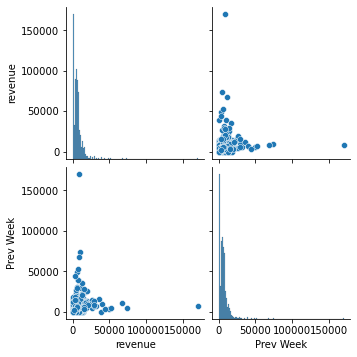

In [20]:
sns.pairplot(data=data_consumption)

In [21]:
#Defining training and test sets
X_train = data_consumption['2018'].drop(['revenue'], axis = 1)
y_train = data_consumption.loc['2018', 'revenue']
X_test = data_consumption['2019'].drop(['revenue'], axis = 1)
y_test = data_consumption.loc['2019', 'revenue']
X_train.head(100)

,Prev Week
date,
2018-01-01,0.0
2018-01-02,0.0
2018-01-03,0.0
2018-01-04,0.0
2018-01-05,0.0
...,...
2018-04-06,0.0
2018-04-07,0.0
2018-04-08,0.0


In [22]:
myts = myts.reset_index()
X_Rev30, y_rev30, mydates = engineer_features(myts,training=False)
print(X_Rev30.head(10))
print(y_rev30[:20])

        date  purchases  unique_invoices  unique_streams  total_views  \
0 2017-11-01          0                0               0            0   
1 2017-11-02          0                0               0            0   
2 2017-11-03          0                0               0            0   
3 2017-11-04          0                0               0            0   
4 2017-11-05          0                0               0            0   
5 2017-11-06          0                0               0            0   
6 2017-11-07          0                0               0            0   
7 2017-11-08          0                0               0            0   
8 2017-11-09          0                0               0            0   
9 2017-11-10          0                0               0            0   

  year_month  revenue  Year  Month  Week  Weekday_Name  
0    2017-11      0.0  2017     11    44             2  
1    2017-11      0.0  2017     11    44             3  
2    2017-11      0.0  20

In [23]:
from sklearn.model_selection import train_test_split
#Defining training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_Rev30,y_rev30,test_size=0.33, shuffle=False)


In [24]:
print(len(X_train), len(y_train))

387 387


In [25]:
#scaling the data
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)

X_train_scaled=transformer.transform(X_train)
X_test_scaled=transformer.transform(X_test)

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
X_train.shape


(387, 7)

In [28]:
type(y_train)

numpy.ndarray

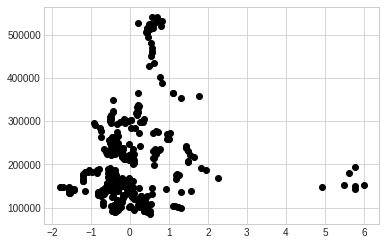

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
x = X_train_scaled[0:387,0]
y = y_train
#plt.axis([0, 25000, 0, 25000])
plt.plot(x, y, 'o', color='black');


# Cross-Validation on Time-Series data

A better alternative for cross validation on time series data (than K-fold CV) is Forward Chaining strategy. In forward chaining, say with 3 folds, the train and validation sets look like: • fold 1: training [1], validation [2] • fold 2: training [1 2], validation [3] • fold 3: training [1 2 3], validation [4] where 1, 2, 3, 4 represent the year. This way successive training sets are supersets of those that come before them. Luckily for us, sklearn has a provision for implementing such train test split using TimeSeriesSplit.


LR: -4.254251 (2.730902)
NN: -12.284452 (10.523363)
KNN: -1.178407 (0.590674)
RF: -1.210520 (0.416379)
SVR: -0.836834 (0.808510)


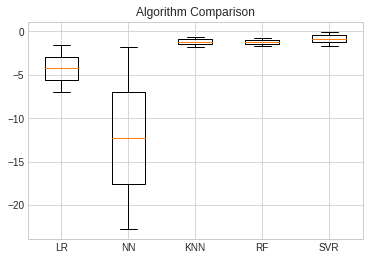

In [30]:
from sklearn.model_selection import TimeSeriesSplit
# Since our training data has 11 unique years (2006 -2016), we would be setting n_splits = 10. This way we have neat training and validation sets

## Spot check Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear# Evaluate each model in turn
results = []
names = []
for name, model in models:    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=2)
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()



In [31]:
print(cv_results)

[-0.02832378 -1.64534331]


In [32]:
#We define our custom scorer as follows:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [33]:
#An optimal combination of hyperparameters maximizes a model’s performance without leading to a high variance problem (overfitting).
#The Python code for performing grid-search is as follows:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
    }
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [34]:
# Checking best model performance on test data
y_true = y_test
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)


explained_variance:  0.1133
mean_squared_log_error:  0.5518
r2:  -2.884
MAE:  72802.427
MSE:  6691809117.0725
RMSE:  81803.4786


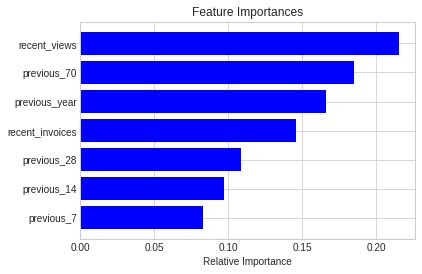

In [35]:
#Variable Importance Plot
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [36]:
print(y_true,y_pred)

[131521.29  134133.25  140815.56  147459.58  152692.77  160245.27
 164240.95  164240.95  166562.67  172752.8   178314.26  184293.11
 183784.64  150880.58  142929.92  137857.52  143213.56  145261.6
 141887.12  140124.43  138111.49  132445.47  127751.59  132126.28
 137656.91  131780.13  133145.43  131491.13  123334.87  119299.03
 136895.7   139856.78  140364.51  138789.02  137063.77  129511.27
 127965.22  135960.62  140898.78  138175.71  138273.34  135549.99
 131732.44  128260.95  139018.93  143552.61  142998.49  141129.8
 147152.34  143689.88  139476.57  143328.26  152610.18  151413.8
 152684.34  165825.79  158015.13  159984.07  162922.83  170591.11
 157772.46  156887.35  155301.41  150232.88  148901.34  158600.75
 165249.26  162394.7   164226.63  165443.92  159784.83  158317.49
 177114.95  180491.66  173503.94  172878.4   177079.46  173355.56
 165990.28  169601.71  171927.77  171098.36  165438.63  170974.741
 162319.071 148046.671 160391.941 162488.031 162787.661 161940.511
 157162.491

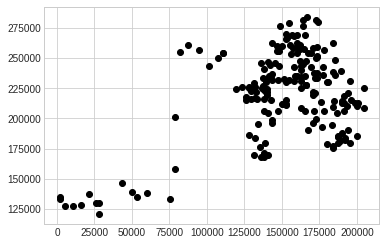

In [37]:
plt.style.use('seaborn-whitegrid')

plt.plot(y_true, y_pred, 'o', color='black');

# Comparing the model with the actual data and with the baseline model


In [38]:
baselineModel = joblib.load(os.path.join(".", "models", "sl-all-0_1.joblib")) ## is the model that was baselinec"
# bestmodel is the model that I just created above

In [39]:
## load data
data_dir = os.path.join("data", "cs-train")
ts_data = fetch_ts(data_dir, clean=True,country="all")
all_data = {}
for country, df in ts_data.items():
    X, y, dates = engineer_features(df, training=False)
    dates = np.array([str(d) for d in dates])
    all_data[country] = {"X": X, "y": y, "dates": dates}
    print(country, "\n",all_data[country])

... > processing data for loading
        date  purchases  unique_invoices  unique_streams  total_views  \
0 2017-11-01          0                0               0            0   
1 2017-11-02          0                0               0            0   
2 2017-11-03          0                0               0            0   
3 2017-11-04          0                0               0            0   
4 2017-11-05          0                0               0            0   
5 2017-11-06          0                0               0            0   
6 2017-11-07          0                0               0            0   
7 2017-11-08          0                0               0            0   
8 2017-11-09          0                0               0            0   
9 2017-11-10          0                0               0            0   

  year_month  revenue  
0    2017-11      0.0  
1    2017-11      0.0  
2    2017-11      0.0  
3    2017-11      0.0  
4    2017-11      0.0  
5    2017-11      

In [40]:
    data = all_data['all']
    query = data['X']

    ## make prediction and gather data for log entry
    y_pred_baseline = baselineModel.predict(query)
    Y_pred_mymodel = best_model.predict(query)

In [41]:
y_pred

array([169940.5273    , 195721.6761    , 204372.16905   , 205744.41655   ,
       211990.08105   , 253768.6232    , 245127.1567    , 281470.2207    ,
       284140.4598    , 281172.5462    , 256233.93035   , 262095.60045   ,
       238593.60635   , 212237.1265    , 214944.7339    , 240774.3403    ,
       237064.3201    , 245709.0644    , 243928.29505   , 232790.33175   ,
       206150.4379    , 221644.4951    , 225208.28045   , 225907.569     ,
       224989.45675   , 217164.61345   , 215638.0459    , 223162.54495   ,
       225737.57495   , 223917.3681    , 225073.93405   , 224223.5536    ,
       221648.5236    , 222679.3743    , 233269.73305   , 222623.38935   ,
       225888.54965   , 167741.4797    , 169732.07475   , 171514.3314    ,
       168373.16936667, 176302.029225  , 184104.3168    , 186283.14285   ,
       179797.82275   , 198432.92625   , 235453.8049    , 235453.8049    ,
       231397.2914    , 231683.7744    , 230409.2465    , 195815.0647    ,
       230098.98655   , 2

In [42]:
# now create a dataframe that combines the real y-values, the baseline y-values an dhte best model y-values in order to ploty a compare chart
dfcompare = pd.DataFrame({'date': dates})
dfcompare=dfcompare.assign(y_real= data['y'])
dfcompare=dfcompare.assign(y_pred_baseline= y_pred_baseline )
dfcompare=dfcompare.assign(Y_pred_mymodel= Y_pred_mymodel )
dfcompare['date'] = pd.to_datetime(df['date'])
#dfcompare=dfcompare.set_index('date')
dfcompare['yymm'] = dfcompare['date'].dt.year.apply(str)+dfcompare['date'].dt.month.apply(str)

dfcompare

,date,y_real,y_pred_baseline,Y_pred_mymodel,yymm
0,2017-11-01,183857.22,182208.61315,182167.351850,201711
1,2017-11-02,170445.26,171634.74285,171308.177500,201711
2,2017-11-03,157155.01,157823.26625,160240.528600,201711
3,2017-11-04,147467.73,149089.37400,147523.762750,201711
4,2017-11-05,147991.02,149272.52550,146749.506500,201711
...,...,...,...,...,...
574,2019-05-29,15767.13,135150.94725,128473.229222,20195
575,2019-05-30,10863.96,136688.59270,127459.103222,20195
576,2019-05-31,5364.58,143321.90415,127406.781438,20195
577,2019-06-01,1793.98,144507.34435,132926.070592,20196


In [43]:
# we create a summary dataframe with the results for the different models by yymm
dfgroup=dfcompare.groupby(["yymm"]).sum()

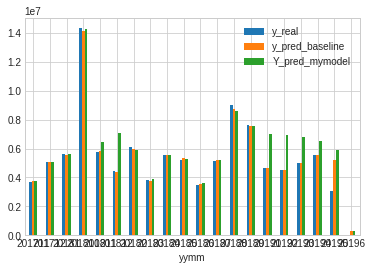

In [44]:
ax= dfgroup.plot.bar(rot=0)

In [ ]:
## it looks like my model is not doing too well especially in the later months